In [ ]:
$# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nithin1729s_multimodal_real_fake_job_posting_prediction_path = kagglehub.dataset_download('nithin1729s/multimodal-real-fake-job-posting-prediction')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv("/kaggle/input/multimodal-real-fake-job-posting-prediction/fake_job_postings.csv")
base_path = "/kaggle/input/multimodal-real-fake-job-posting-prediction/images"
df['webpage_screenshot'] = df.apply(lambda x: f"{base_path}/{x['fraudulent']}/{x['job_id']}.png", axis=1)

print(df.loc[0])

job_id                                                                 1
title                                                   Marketing Intern
location                                                US, NY, New York
department                                                     Marketing
salary_range                                                         NaN
company_profile        We're Food52, and we've created a groundbreaki...
description            Food52, a fast-growing, James Beard Award-winn...
requirements           Experience with content management systems a m...
benefits                                                             NaN
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          0
employment_type                                                    Other
required_experience                                

In [ ]:
# Core
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, PrecisionRecallDisplay
)

# Pretty plots
sns.set(style="whitegrid", context="talk")
np.random.seed(42) #helps make the split and plots reproducible


In [ ]:
# Make sure needed columns exist
for c in ["title", "description", "requirements"]:
    if c not in df.columns:
        df[c] = ""

# Safer concat with spaces + simple whitespace cleanup
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["requirements"].fillna("")
).str.replace(r"\s+", " ", regex=True).str.strip()

# Drop rows with missing target if any and coerce to int
df = df.dropna(subset=["fraudulent"])
y = df["fraudulent"].astype(int)
X = df["text"]

# Stratified split keeps class balance: preserves the fraud/real ratio in train and test, which stabilizes metrics
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")


Train: 14304, Test: 3576


In [ ]:
pipe_cnb = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),     # word unigrams + bigrams
        max_features=15000,     # keep vocabulary size reasonable
        min_df=2                # drop ultra-rare noise
    )),
    ("clf", ComplementNB(alpha=0.5, norm=True))
])

pipe_cnb.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=15000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', ComplementNB(alpha=0.5, norm=True))])

              precision    recall  f1-score   support

           0      0.972     0.996     0.984      3403
           1      0.860     0.428     0.571       173

    accuracy                          0.969      3576
   macro avg      0.916     0.712     0.778      3576
weighted avg      0.966     0.969     0.964      3576

ROC AUC: 0.920


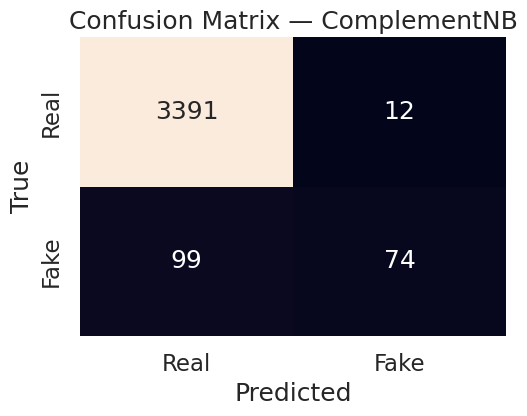

PR AUC: 0.646


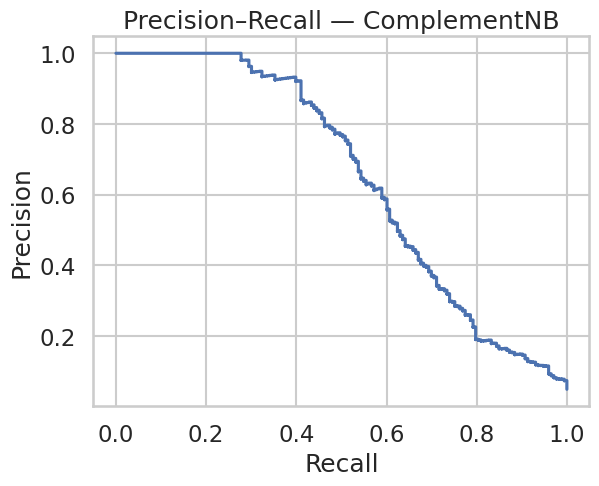

In [ ]:
# Predictions & probabilities
y_pred = pipe_cnb.predict(X_test)
y_proba = pipe_cnb.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred, digits=3))

# ROC AUC
roc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — ComplementNB")
plt.tight_layout()
plt.show()

# Precision–Recall curve (more informative on imbalance)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.3f}")

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision–Recall — ComplementNB")
plt.show()


In [ ]:
# Extract per-token log-probs and compute discriminativeness
tfidf = pipe_cnb.named_steps["tfidf"]
clf   = pipe_cnb.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
# feature_log_prob_: shape = (n_classes, n_features), classes_[0]=0 (Real), classes_[1]=1 (Fake)
log_prob = clf.feature_log_prob_
diff = log_prob[1] - log_prob[0]   # positive => pushes toward Fake

top_n = 25
top_fake_idx = np.argsort(diff)[-top_n:][::-1]
top_real_idx = np.argsort(diff)[:top_n]

pd.set_option("display.max_colwidth", None)

print("Top tokens indicating FAKE:")
display(pd.DataFrame({
    "token": feature_names[top_fake_idx],
    "logprob_diff": diff[top_fake_idx]
}).reset_index(drop=True))

print("\nTop tokens indicating REAL:")
display(pd.DataFrame({
    "token": feature_names[top_real_idx],
    "logprob_diff": diff[top_real_idx]
}).reset_index(drop=True))


Top tokens indicating FAKE:


,token,logprob_diff
0,subsea,0.000030
1,extra day,0.000030
2,aker,0.000030
3,aker solutions,0.000029
4,accepting online,0.000029
5,onlyclick apply,0.000029
6,onlyclick,0.000029
7,applications onlyclick,0.000029
8,ultra luxury,0.000028
9,typist,0.000027



Top tokens indicating REAL:


,token,logprob_diff
0,university degree,-0.000019
1,living,-0.000019
2,tefl,-0.000018
3,teaching experience,-0.000018
4,asia,-0.000018
5,kids,-0.000018
6,tesol,-0.000018
7,tefl tesol,-0.000018
8,celta,-0.000018
9,student loans,-0.000018
